# Customer Reviews: NLP Topic Modeling

## Define Task

Online product reviews are a great source of information for consumers. From the sellers’ point of view, online reviews can be used to gauge the consumers’ feedback on the products or services they are selling. However, since these online reviews are quite often overwhelming in terms of numbers and information, an topic modeling system, capable of finding key insights (topics) from these reviews, will be of great help for both the consumers and the sellers.

In this notebook, I will use the Olist e-commerce dataset to perform a topic modeling analysis on customer reviews to find out what are the main topics that customers talk about in their reviews. 

For that analysis, I will be using the Latent Dirichlet Allocation (LDA) in order to find the hidden topics within the text data. LDA is a type of probability distribution (i.e. every document is a probability distribution of topics, and every topic is a probability distribution of words).

I will be comparing two types of LDA models, the multicore and the mallet, to see which model performs better in extracting the topics from the documents/text data (the performance metrics that I will assess are perplexity and coherence scores).

#### Import core packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('Core packages have been successfully loaded.')

Core packages have been successfully loaded.


In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Import dataset & extract feature of interest

In [3]:
#Import dataset
df = pd.read_csv('/Users/Coding/Desktop/E-commerce/order_reviews_dataset.csv')

#Display top entries
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_english
0,e2e44e3eeaa2d29e879b35578df28569,ec864a967206dcb874a7db0ffa6fb17d,5,0,0,2018-04-28 0:00:00,2018-05-03 13:09:43,0
1,22da30dde9db9742eef832df2e82018c,adddc7adab7516dd578d700024245d43,1,0,0,2018-07-26 0:00:00,2018-07-30 21:44:40,0
2,532bd7f1a84d53519ee94e47a8fdd5ba,39cdf001e42cd975d9ea5e05990f2b61,5,Wagner,100%,2018-08-17 0:00:00,2018-08-22 3:06:09,100%
3,c90bf23aaba3fd9a2712864a04fd7ba2,23d2b40718f8b1693ff67644c21d9f70,5,NaN,100%,2017-09-01 0:00:00,2017-09-03 14:30:24,100%
4,e98c4c4fb9bd358090c29cfd94129f67,62b0ada629089f119f6445bd01ebaaf1,5,NaN,100%,2017-12-13 0:00:00,2017-12-14 22:31:09,100%


In [4]:
#Extract the reviews left by customers and drop all NAs from dataset
reviewsData = df.loc[:, ['review_english']]
reviewsData = reviewsData.dropna(subset = ['review_english'])
reviewsData = reviewsData.reset_index(drop = True)

#Get the shape of the dataset
print(f'Dataset shape: {reviewsData.shape}')
print('-' * 50)

#Rename column to 'comment'
reviewsData.columns = ['review']

#Display new dataset
reviewsData

Dataset shape: (41728, 1)
--------------------------------------------------


,review
0,0
1,0
2,100%
3,100%
4,100%
...,...
41723,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...
41724,Y
41725,Zero
41726,Zero did not deliver and do not give satisfact...


## Text Preprocessing

In this part of the analysis, I will perfrom some text preprocssing (changing to lowercase, removing nonsensical words, removing numeric data, removing stopwords, text lemmatization, etc.) in order to transform the text data into a more digestible form so that the LDA model performs better.

#### Preliminary Step - create dictionary (list) to display text data

In [5]:
#Create and display dictionary
dict = reviewsData.to_dict('list')
dict

{'review': ['0',
  '0',
  '100%',
  '100%',
  '100%',
  '100%',
  '100%',
  '3',
  '4',
  '5',
  '5',
  '5',
  '8',
  '8',
  '9',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '10',
  '\n\n\nOf any request made on the site, this was the one that took to deliver !!!',
  '\n\nThere was a reported impediment in another email explaining the delay of product delivery.\nThat time have not received the purchase.\nI await information\nPatricia',
  '\n\nlannister.com (atendimento@lannister.com)\nGood afternoon to my disappointment did exchange ruim.ou product is I replace the drum and toner, empty toner and drum empty.',
  '\n\nRechargeable Battery Kit 4 Aaa Batteries 2700 Mah 1.2V Ni Mh',
  '\n\nI recommend.',
  '\n.',
  '\nDespite being delivered ahead of schedule, delivery time is very longo.Enfim more because the post is even garbage. Apart from that product in perfect condition. I recommend!

After observing the content of the reviews, I decided to perform the following text transformations to get a final clean dataset:
1. Remove all numeric entries
2. Change to lowercase so that the text is uniform
3. Remove breaks (the indent between texts)
4. Remove all the dates
5. Remove emojis and special characters
6. Remove text inside paranthesis
7. Remove whitespaces
8. Remove all stopwords
9. Text lemmatization

#### Round 1: Cleaning with regex

In [6]:
#Import packages for regex cleaning
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in paranthesis, remove punctuations, numeric data, special characters, etc.'''
    text = text.lower() #change to lowercase
    text = re.sub('\(.*?\)', '', text) #remove text within paranthesis
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #remove punctuation marks
    text = re.sub('\w*\d\w*', '', text) #remove numerics
    text = re.sub('[‘’“”…]', '', text)  #get rid of useless quotations
    text = re.sub('[\n\r]', ' ', text) #get rid of breaks
    text = re.sub('\W', ' ', text) #remove special characters (i.e. emojis)
    text = re.sub('\s+', ' ', text) #remove whitespaces beginning word
    text = re.sub('[ \t]+$', '', text) #remove whitespaces from end of word
    
    return text

clean = lambda x: clean_text(x)

In [7]:
#Apply the function
reviews_clean1 = pd.DataFrame(reviewsData.review.apply(clean))

#Display the data after first round of cleaning
reviews_clean1;

#### Round 2: Wordcloud top 100 words and removing stopwords/nonsensical words

I will plot a wordcloud displaying the 100 most frequent words in all the documents (reviews). The main reason of doing that is to see if the most frequent words make sense to keep or is it best to eliminate them for topic modeling (i.e. some words appear many times but have no added value since they are obvious in context; the word 'product' can appear several times but it is only because people buy different types of products from e-commerce websites so removing this word from our text data is an essential step to get useful topics.

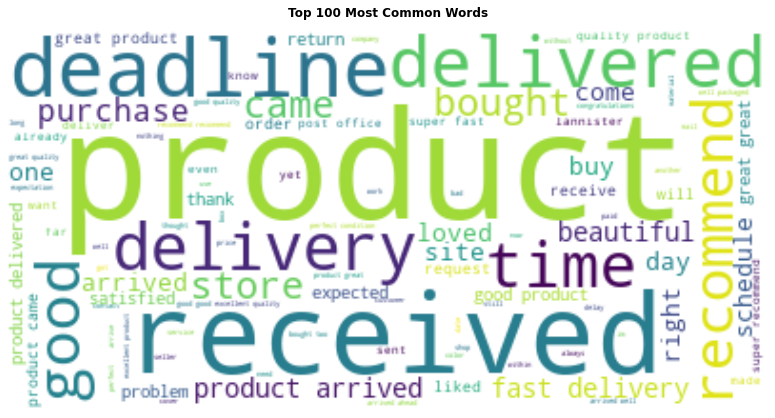

In [8]:
#Import wordcloud package
from wordcloud import WordCloud

#Join the reviews into new variable
review_long_string = ','.join(list(reviews_clean1.review.values))

#Create a wordcloud object
wordcloud = WordCloud(background_color = "white", max_words = 100, contour_width = 3, contour_color = 'steelblue')

#Generate word cloud
wordcloud.generate(review_long_string)

#Set the title and fig size
plt.figure(figsize = (20,7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Top 100 Most Common Words", pad = 14, weight = 'bold')

#Display plot
plt.show()

In [9]:
#Import nltk stopwords
from nltk.corpus import stopwords

#Define stopwords and display size of stopwords list before adding new words
stop_words = stopwords.words('english')
print('Original stopwords list size:', len(stop_words))
print('-' * 35)

#Add nonsensical words to be removed as well
stop_words.extend(['product', 'received', 'delivered', 'arrived', 'bought', 'store', 'deliver', 'day', 'time', 'buy',
                   'came', 'products', 'yet', 'two', 'one', 'right', 'purchase', 'site', 'come', 'everything', 'get',
                   'within', 'made', 'always', 'sent', 'im', 'request', 'expected', 'order', 'delivery', 'schedule',
                   'deliveries', 'q', 'recommend', 'deadline', 'loved', 'beautiful', 'good', 'yet', 'great', 'bad',
                   'excellent', 'expected', 'congratulations', 'would', 'still', 'well', 'super', 'perfect', 'ahead',
                   'like', 'liked', 'satisfied', 'already', 'far', 'days', 'waiting', 'ok', 'want', 'without', 'paid',
                   'thank', 'even', 'receive', 'date', 'know', 'got', 'nothing', 'much', 'service', 'different',
                   'expectations', 'seller', 'company', 'need', 'could', 'really', 'condition', 'enjoyed', 'another',
                   'purchased', 'purchase', 'little', 'best', 'packaging', 'worst', 'today', 'top', 'yesterday',
                   'shopping', 'td', 'hope', 'afternoon', 'morning', 'night', 'lot', 'promised', 'informed', 'answer',
                   'upset', 'otimo', 'mto', 'big', 'small', 'arrive', 'thing', 'absurd', 'ontime', 'thank', 'item',
                   'lack', 'preiod', 'way', 'shop', 'week', 'simple', 'several', 'wonderful', 'worth', 'however',
                   'first', 'took', 'gift', 'addition', 'cool', 'advance', 'american', 'finish', 'buying',
                   'surprised', 'efetuei', 'expectation', 'full', 'open', 'incomplete', 'urgent', 'rest', 'happy',
                   'hour', 'stuff', 'moment', 'congratulated', 'situation', 'talk', 'normal', 'end', 'early',
                   'bit', 'benefit', 'nice', 'fast', 'cute', 'month', 'disappointed', 'work', 'sale', 'period',
                   'status', 'thought', 'contacted', 'show', 'paraben', 'shaft', 'quick', 'time', 'optimal', 'due',
                   'cancellation', 'delay', 'satisfaction', 'guy', 'box', 'goods', 'use', 'never', 'back', 'pleased',
                   'long', 'fit', 'respect', 'quality', 'unit', 'stock', 'house', 'daughter', 'problem', 'packaged',
                   'correct', 'packed', 'asked', 'ordered', 'give', 'requested', 'found', 'term', 'contact',
                   'problems', 'make', 'thanks'])

#Get the final stopwords list size
print('Final stopwords list size:', len(stop_words))

Original stopwords list size: 179
-----------------------------------
Final stopwords list size: 378


In [10]:
#Define function that removes stopwords/nonsensical words
def remove_stopwords(text):
    text_new = " ".join([i for i in text if i not in stop_words])
    return text_new

#Remove stopwords from the text
reviews_clean2 = [remove_stopwords(r.split()) for r in reviews_clean1['review']]

#Display dataset after stopwords removal
reviews_clean2;

#### Check the top 20 frequent words after removal of stopwords/nonsencial words

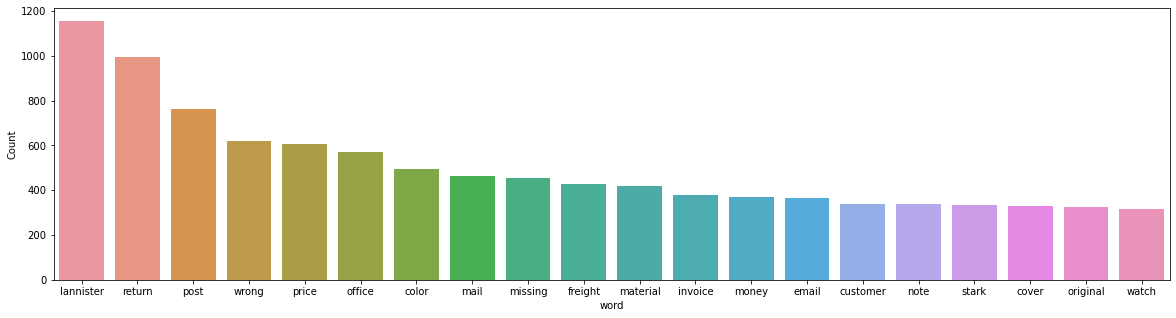

In [11]:
#Import freqdist package from nltk
from nltk import FreqDist

#Define function to plot 20 most frequent terms
def freq_words(x, terms = 20):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    #Get the frequency distribution
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})
    
    #Select top n most frequent words
    d = words_df.nlargest(columns = 'count', n = terms)
    
    #Define the plot axes and size
    plt.figure(figsize = (20,5))
    ax = sns.barplot(data = d, x = 'word', y = 'count')
    ax.set(ylabel = 'Count')
    plt.show()
    
#Plot
freq_words(reviews_clean2, 20)

From the above frequency distribution graph, we can notice that 'lannister' is the most frequent word which is something related to Game of Thrones. This indicates that people are ordering a lot of products with the GoT theme. The second most frequent word is 'return' which can indicate that there are a lot of people who returned their order because of several reasons (defected, wrong product, etc.).

Knowing what people are talking about the most can be important for the sellers. In this case, many people are buying GoT themed products, so they can increase the sale of such products or offer discounts or loyalty programs on said products.

Also, sellers can also see that many people are returning the products after purchase. To tackle that, they can try to ensure optimal quality of products and that there are no mistakes when sending out the orders.

#### Round 4: Text lemmatization with spaCy

To further remove noise from the text, I will lemmatize the data using spaCy to reduce any given word to its base form. This reduces the multiple forms of a word to a single word (i.e delivery/delivered/delivering --> deliver).

In [12]:
#Import spacy package
import spacy

#Define the model
nlp = spacy.load('en_core_web_sm',  disable = ['parser', 'ner'])

#Define function that lemmatizes text data
def lemmatization(texts, tags = ['NOUN', 'ADJ', 'PROPN']): #keep nouns, adjectives and proper nouns
    output = []
    for sent in texts:
        doc = nlp(' '.join(sent))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [13]:
#Tokenize reviews before lemmatizing
tokenized_reviews = pd.Series(reviews_clean2).apply(lambda x: x.split())

#Print a sample output for comparison
print(tokenized_reviews[100])

['residence', 'post', 'office', 'attendants', 'us', 'poor', 'speak', 'anything', 'enclose', 'solution']


In [14]:
#Apply the defined lemmatization function
reviews_clean2 = lemmatization(tokenized_reviews)

#Print sample output for comparison
print(reviews_clean2[100])

['residence', 'post', 'office', 'poor', 'solution']


## Building LDA model

LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.

LDA assumes that the every chunk of text fed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial for achieving the best performance. It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution.

I will test 2 types of LDA models, the multicore LDA model and the Mallet LDA, and see which model performs better based on the coherence scores and perplexity scores.

### A. LDA Multicore

#### Create a dictionary that quantifies unique terms as well as a corpus to get the TDF

In [15]:
#Import corpora package from gensim
from gensim import corpora

#Create dictionary where every unique term is assigned an index
id2word_1 = corpora.Dictionary(reviews_clean2)

#Create corpus using the dictionary to get term document frequency
corpus_1 = [id2word_1.doc2bow(review) for review in reviews_clean2]

#### Build the LDA multicore model

In [16]:
#Import LDA package
from gensim.models.ldamulticore import LdaMulticore

#Initialize the LDA multicore model
lda_model_multicore = LdaMulticore(corpus = corpus_1, num_topics = 8, id2word = id2word_1, chunksize = 2000,
                        passes = 50, per_word_topics = True)

#### Display generated topics

In [17]:
#Import pprint package in order to display topics in a more legible manner
from pprint import pprint

#Display topics
pprint(lda_model_multicore.show_topics(formatted = False))

[(0,
  [('price', 0.070870556),
   ('original', 0.035604395),
   ('cartridge', 0.023406433),
   ('package', 0.023100575),
   ('poor', 0.022578457),
   ('curtain', 0.020883653),
   ('control', 0.015734263),
   ('plastic', 0.00947114),
   ('message', 0.0076830736),
   ('fabric', 0.0076806094)]),
 (1,
  [('lannister', 0.09107858),
   ('store', 0.024274282),
   ('partner', 0.02300517),
   ('cover', 0.02231405),
   ('film', 0.020309826),
   ('phone', 0.018257547),
   ('reliable', 0.016028985),
   ('efficient', 0.015006415),
   ('announcement', 0.013248019),
   ('shop', 0.012543038)]),
 (2,
  [('color', 0.051214073),
   ('clock', 0.02513426),
   ('photo', 0.024976343),
   ('black', 0.022972044),
   ('note', 0.019436907),
   ('unit', 0.016445125),
   ('love', 0.01452211),
   ('light', 0.01279125),
   ('part', 0.011594022),
   ('thin', 0.011537917)]),
 (3,
  [('material', 0.04517977),
   ('kit', 0.03021358),
   ('stark', 0.02963054),
   ('picture', 0.02265003),
   ('easy', 0.02052711),
   ('pi

Examples of topics displayed:

**Topic 1:** revolves around curtains that have poor fabric

**Topic 2:** revolves around lannister themed phone covers

**Topic 3:** revolves around clocks

#### Compute perplexity score and coherence score

In [18]:
#Import package
from gensim.models import CoherenceModel

#Compute Perplexity to see how good the model is
print('Perplexity: ', lda_model_multicore.log_perplexity(corpus_1))  
print('-' * 50)

#Compute coherence score
coherence_model_lda = CoherenceModel(model = lda_model_multicore, texts = reviews_clean2,
                                     dictionary = id2word_1, coherence ='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('LDA multicore model coherence score: ', coherence_lda)

Perplexity:  -8.239662031265535
--------------------------------------------------
LDA multicore model coherence score:  0.45254956313459604


Looking at the scores above, one can conclude that the multicore LDA has done a decent job in extracting the topics for each document (coherence score of 0.45).

I will try using the LDA mallet in the next part to see if I can manage to get better scores than the multicore model.

### B. LDA Mallet

In this section, I will be using the LDA Mallet model. Mallet has an efficient implementation of the LDA. It's known to run faster and give better topics segregation. The LDA mallet uses Gibbs sampling based implementations of Latent Dirichlet Allocation (LDA), Pachinko allocation and hierarchical LDA.

#### Create a dictionary that quantifies unique terms as well as a corpus to get the TDF

In [19]:
#Create dictionary where every unique term is assigned an index
id2word_2 = corpora.Dictionary(reviews_clean2)
print('Total vocabulary Size:', len(id2word_2))

#Create corpus using the dictionary to get term document frequency
corpus_2 = [id2word_2.doc2bow(review) for review in reviews_clean2]
print('Total corpus Size:', len(corpus_2))

Total vocabulary Size: 10264
Total corpus Size: 41728


#### Create dataframe showing each word in the corpus along with its frequency

In [20]:
#Initialize empty dictionary
dict_corpus = {}

#Loop in the corpus eo extract the words and frequencies
for i in range(len(corpus_2)):
    for idx, freq in corpus_2[i]:
        if id2word_2[idx] in dict_corpus:
            dict_corpus[id2word_2[idx]] += freq
        else:
            dict_corpus[id2word_2[idx]] = freq

#Convert to dataframe
dict_df = pd.DataFrame.from_dict(dict_corpus, orient = 'index', columns = ['freq'])
dict_df.head(10)

,freq
await,82
email,420
impediment,1
information,262
patricia,1
disappointment,42
drum,3
empty,22
exchange,303
lannistercom,147


#### Plot histogram of word frequencies

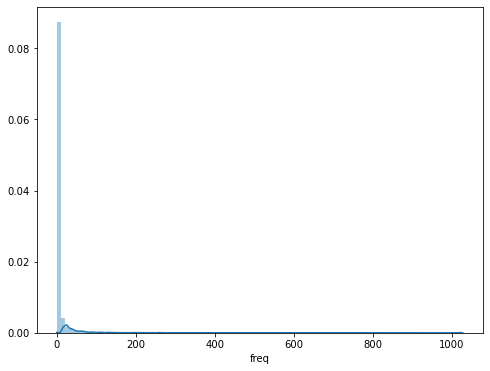

In [21]:
#Plot the histogram
plt.figure(figsize = (8,6))
sns.distplot(dict_df['freq'], bins = 100)

It can be seen from the above histogram that some words have a much higher frequency when compared to the majority of other words.

#### Ge the mallet path and initialize model

In [22]:
#Import mallet package
from gensim.models.wrappers import LdaMallet

#Get the mallet path stored on os
mallet_path = '/Users/Coding/Desktop/Python/mallet-2.0.8/bin/mallet'

#Initialize the model
lda_mallet = LdaMallet(mallet_path, corpus = corpus_2, num_topics = 8, id2word = id2word_2)

#### Display generated topics

In [23]:
#Show Topics
pprint(lda_mallet.show_topics(formatted = False))

[(0,
  [('return', 0.09044600407516414),
   ('application', 0.025016979850577315),
   ('note', 0.024337785827484717),
   ('card', 0.02275299977360199),
   ('model', 0.022187004754358162),
   ('change', 0.02196060674666063),
   ('amount', 0.018904233642743944),
   ('control', 0.017093049581163686),
   ('refund', 0.01664025356576862),
   ('broken', 0.01550826352728096)]),
 (1,
  [('price', 0.07243146868731892),
   ('material', 0.048584800534878535),
   ('guy', 0.028972587474927567),
   ('low', 0.0234009360374415),
   ('chair', 0.022398038778694004),
   ('poor', 0.02206373969244484),
   ('easy', 0.02206373969244484),
   ('high', 0.018497882772453754),
   ('efficient', 0.018497882772453754),
   ('care', 0.01415199465121462)]),
 (2,
  [('original', 0.03650775929440661),
   ('photo', 0.03583789215138997),
   ('size', 0.03170704476945406),
   ('cartridge', 0.026683041196829297),
   ('film', 0.026683041196829297),
   ('defective', 0.026459752149157086),
   ('phone', 0.022440549291057273),
   (

Examples of topics displayed:

**Topic 1:** revolves around note cards

**Topic 2:** revolves around chairs that had low quality material

**Topic 3:** revolves around phones

#### Find the coherence score (before optimizing number of topics)

In [24]:
#Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = lda_mallet, texts = reviews_clean2,
                                           dictionary = id2word_2, coherence = 'c_v')

coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Mallet Coherence Score: ', coherence_ldamallet)

Mallet Coherence Score:  0.41644788387823617


Just to do a quick comparison before finding the optimal number of topics, the LDA multicore model had a coherence score 0.452 compared to the mallet model that has a coherence score of 0.416. At this point, I conclude that the multicore model performs better in terms of topic discovery.

I will try to improve the score on the mallet model by simply identifying the optimal number of topics to run the algorithm on.

#### Find optimal number of topics

In [25]:
#Define a function to get the coherence scores for every number of topics
def my_coherence_vals(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus = corpus_2, num_topics = num_topics, id2word = id2word_2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
#Get coherence scores
model_list, coherence_values = my_coherence_vals(dictionary = id2word_2, corpus = corpus_2, 
                                                 texts = reviews_clean2, start = 2, limit = 40, step = 6)

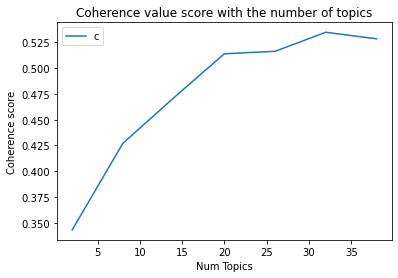

In [27]:
#Plot graph showing the coherence value scores vs number of topics
limit = 40; start = 2; step = 6;
topics = range(start, limit, step)
plt.plot(topics, coherence_values)
plt.title("Coherence value score with the number of topics")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

In [28]:
#Print coherence scores
for best, cv in zip(topics, coherence_values):
    print("Num Topics: ", best, " has Coherence Value of", round(cv, 4))

Num Topics:  2  has Coherence Value of 0.343
Num Topics:  8  has Coherence Value of 0.427
Num Topics:  14  has Coherence Value of 0.4711
Num Topics:  20  has Coherence Value of 0.514
Num Topics:  26  has Coherence Value of 0.5164
Num Topics:  32  has Coherence Value of 0.5349
Num Topics:  38  has Coherence Value of 0.5285


I will choose the model that has 20 topics with a coherence score of 0.514 because it is at this point where the curve starts to flatten out.

#### Use the optimal number of topics to build new model and get new topics

In [29]:
#Display best topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted = False)
pprint(optimal_model.print_topics(num_words = 10))

[(0,
  '0.073*"cover" + 0.066*"film" + 0.056*"phone" + 0.050*"bag" + '
  '0.043*"plastic" + 0.032*"glass" + 0.027*"support" + 0.022*"screen" + '
  '0.021*"machine" + 0.018*"cell"'),
 (1,
  '0.190*"post" + 0.155*"office" + 0.123*"mail" + 0.040*"home" + '
  '0.030*"carrier" + 0.025*"residence" + 0.022*"freight" + 0.016*"fault" + '
  '0.014*"risk" + 0.013*"agency"'),
 (2,
  '0.074*"clock" + 0.062*"application" + 0.057*"note" + 0.021*"star" + '
  '0.021*"condition" + 0.020*"care" + 0.020*"bracelet" + 0.018*"brush" + '
  '0.018*"agility" + 0.016*"grade"'),
 (3,
  '0.073*"information" + 0.054*"model" + 0.050*"reliable" + 0.046*"item" + '
  '0.037*"place" + 0.032*"high" + 0.031*"website" + 0.029*"battery" + '
  '0.021*"measure" + 0.021*"fact"'),
 (4,
  '0.149*"color" + 0.089*"original" + 0.069*"black" + 0.065*"cartridge" + '
  '0.031*"white" + 0.025*"red" + 0.023*"blue" + 0.023*"lamp" + 0.019*"printer" '
  '+ 0.018*"ink"'),
 (5,
  '0.179*"price" + 0.117*"material" + 0.058*"low" + 0.042*"contr

#### Create a dataframe of the term-topic matrix

In [30]:
#Set column width
pd.set_option('display.max_colwidth', -1)

#Get the topic modeling results of the whole document
tm_results = optimal_model[corpus_2]

#Get the most dominant topic of each document
corpus_topics = [sorted(topics, key = lambda record: -record[1])[0] for topics in tm_results]

#Get most probable words for the given topic ID
#I will use the show_topic() method;
#It returns sequence of probable words, as a list of (word, word_probability) for specific topics
topics = [[(term, round(wt, 3)) for term,
           wt in optimal_model.show_topic(n, topn = 19)] for n in range(0, optimal_model.num_topics)]

#Build the term-topic matrix
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics],
                         columns = ['Terms per Topic'],
                         index = ['Topic '+str(t) for t in range(1, optimal_model.num_topics + 1)] )

#Display dataframe
topics_df

,Terms per Topic
Topic 1,"cover, film, phone, bag, plastic, glass, support, screen, machine, cell, protection, hood, mobile, transport, standard, tv, bubble, tape, portfolio"
Topic 2,"post, office, mail, home, carrier, residence, freight, fault, risk, agency, city, center, order, attempt, notice, disorder, failure, area, withdraw"
Topic 3,"clock, application, note, star, condition, care, bracelet, brush, agility, grade, question, point, doubt, grateful, track, dirty, difficult, experience, cotton"
Topic 4,"information, model, reliable, item, place, high, website, battery, measure, fact, detail, put, fake, trace, voltage, replica, recomento, warranty, equal"
Topic 5,"color, original, black, cartridge, white, red, lamp, blue, printer, ink, pink, hp, compatible, toner, pendant, yellow, green, print, brown"
Topic 6,"price, material, low, control, fragile, weak, cost, device, work, fair, result, vendor, satisfactory, punctual, affordable, remote, straight, difference, great"
Topic 7,"chair, poor, piece, thin, fabric, towel, advertising, horrible, soft, comment, false, hair, request, seat, hole, assemble, impression, thick, object"
Topic 8,"photo, picture, description, ad, brand, supplier, match, merchandise, receipt, frame, terrible, type, clear, car, accordance, button, coz, pq, consumer"
Topic 9,"image, speed, process, safe, test, option, son, cancel, trust, month, efficiency, attentive, mt, exelente, procon, toy, tough, door, error"
Topic 10,"size, easy, carpet, large, light, practical, baby, base, small, hour, comfortable, blanket, big, strong, installation, comfort, ideal, network, install"


#### Wordcloud most frequent words for each topic

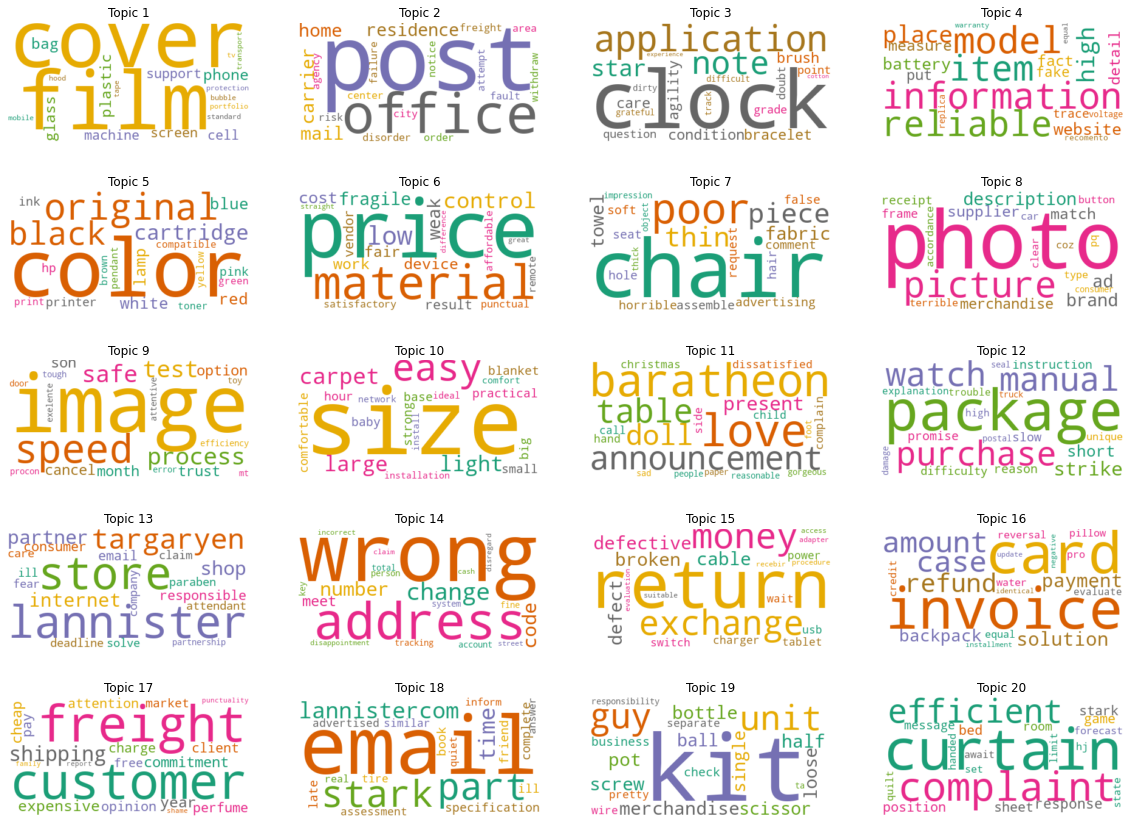

In [31]:
#Initialize wordcloud
wc = WordCloud(background_color = "white", colormap = "Dark2", max_font_size = 150, random_state = 42)

#Set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

#Create subplots for each topic
for i in range(20):
    wc.generate(text = topics_df["Terms per Topic"][i])
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation = "bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

#Display wordcloud
plt.show()

From the above wordclouds we can deduce that:

**Topic 1:** phones (screens, screen protector and plastic covers)

**Topic 2:** post office and the carriers that deliver

**Topic 3:** smart bracelet that has a clock and applications with different functionalities

**Topic 4:** finding reliable information on the websites (i.e identify non scam products)

**Topic 5:** printers and color cartridges

**Topic 6:** prices

**Topic 7:** chairs and their fabric

**Topic 8:** products not being like the photos

**Topic 9:** efficiency in delivering

**Topic 10:** carpets and blankets

**Topic 11:** game of thrones products mainly Baratheon (tables, dolls)

**Topic 12:** watches

**Topic 13:** game of thrones products mainly Lannister and Targaryen

**Topic 14:** delivering to wrong addresses

**Topic 15:** defective products and returning orders

**Topic 16:** invoices and refunds

**Topic 17:** freight and shipping

**Topic 18:** game of thrones products on lannister.com

**Topic 19:** desk accessories (scissors, kit, bottle)

**Topic 20:** bedroom curtains, sheets and beds

## Visualize with pyLDAvis

#### Convert LDA mallet into gensim model

I will have to convert the LDA mallet model into a gensim model in order to be able to use the pyLDAvis package.

In [32]:
#Import Ldamodel
from gensim.models.ldamodel import LdaModel

#Define function to convert Mallet model
def convertldaMalletToldaGen(optimal_model):
    model_gensim = LdaModel(
        id2word = optimal_model.id2word, num_topics = optimal_model.num_topics,
        alpha = optimal_model.alpha) 
    model_gensim.state.sstats[...] = optimal_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

#Call the function on the lda mallet model
ldagensim = convertldaMalletToldaGen(optimal_model)

#### Visualize

In [33]:
#Import pyLDAvis packages
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

#Generate the plot
vis_data = gensimvis.prepare(ldagensim, corpus_2, id2word_2, sort_topics = False)
pyLDAvis.display(vis_data)

The area of circle represents the importance of each topic over the entire corpus. The distance between the center of circles indicate the similarity between topics. For each topic, the histogram on the right side lists the top 30 most relevant terms.

## Finalize with topic dominance

#### Get dominant topic for each document and its % in the document

In [34]:
#Create the dataframe
corpus_topic_df = pd.DataFrame()

#Append the dataframe adding features of interest
corpus_topic_df['dominant topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['topic terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]

#Display dataframe
corpus_topic_df.tail()

,dominant topic,contribution %,topic terms
41723,16,6.43,"invoice, card, amount, case, refund, payment, solution, backpack, pillow, credit, water, equal, reversal, pro, evaluate, identical, installment, negative, update"
41724,1,5.00,"cover, film, phone, bag, plastic, glass, support, screen, machine, cell, protection, hood, mobile, transport, standard, tv, bubble, tape, portfolio"
41725,1,5.00,"cover, film, phone, bag, plastic, glass, support, screen, machine, cell, protection, hood, mobile, transport, standard, tv, bubble, tape, portfolio"
41726,15,6.86,"return, money, exchange, defective, broken, cable, defect, charger, switch, power, tablet, wait, usb, procedure, access, evaluation, adapter, recebir, suitable"
41727,12,6.21,"package, purchase, manual, watch, strike, short, promise, slow, reason, instruction, difficulty, unique, explanation, high, trouble, postal, damage, seal, truck"


The above dataframe displays the dominant topic for each document (review).

#### Get the document counts for each topic and its percentage in the corpus with chaining agg function

In [36]:
#Group all topics
dominant_topic_df = corpus_topic_df.groupby('dominant topic').agg(
                                  Doc_Count = ('dominant topic', np.size),
                                  Total_Docs_Perc = ('dominant topic', np.size)).reset_index()

#Add the % column to the dataframe
dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus_2), 2))

#Display dataframe
dominant_topic_df

,dominant topic,Doc_Count,Total_Docs_Perc
0,1,19018,45.58
1,2,1415,3.39
2,3,1418,3.40
3,4,1497,3.59
4,5,1181,2.83
5,6,1578,3.78
6,7,1237,2.96
7,8,1228,2.94
8,9,1308,3.13
9,10,1217,2.92


From the above dataframe we can see how many documents belong to a particular topic as well as the percentage dominance of topics. We can see that topic 1 dominates the entire corpus of documents with 45.58% with the least dominant topic being the 20th with 2.45%.